In [5]:
import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt

# System Parameters

In [6]:
image_file = "img\continuous_maze1.jpeg"

# Read Maze Image

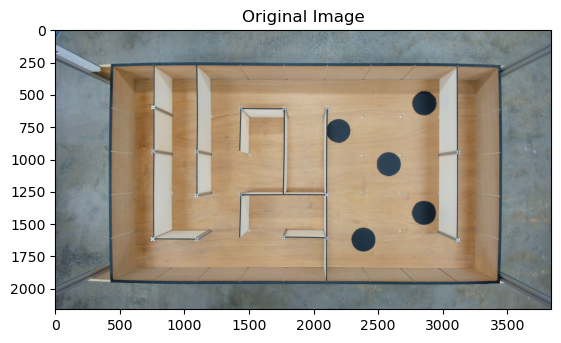

In [7]:
image = cv2.imread(image_file)

# Display the original image
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.show()


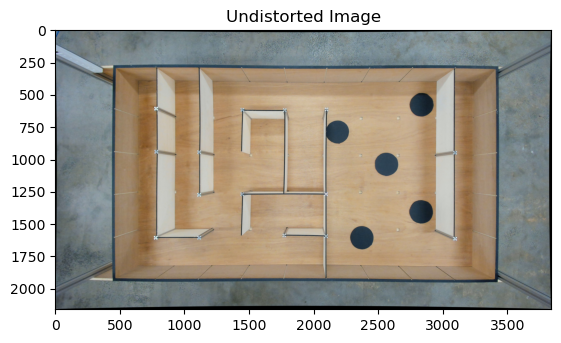

In [12]:
fx = 10000
fy = 10000
cx = image.shape[1] / 2
cy = image.shape[0] / 2
k1 = -0.5
k2 = 0.5
p1 = 0
p2 = 0

K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])
D = np.array([k1, k2, p1, p2])

# Undistort the image
h, w = image.shape[:2]
new_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(K, D, (w, h), 1, (w, h))
undistorted_image = cv2.undistort(image, K, D, None, new_camera_matrix)

plt.imshow(cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2RGB))
plt.title('Undistorted Image')
plt.show()

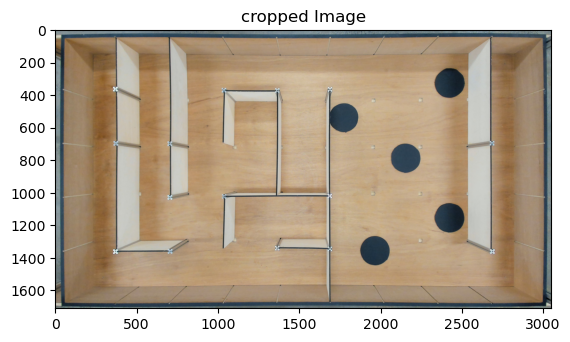

In [13]:
M = cv2.getRotationMatrix2D((cx, cy), 0.2, 1.0)
# Rotate image
rotated_image = cv2.warpAffine(undistorted_image, M, (w, h))
cropped_image = rotated_image[250:(h-200), 410:(w-380)]
cv2.imwrite("img/cropped_maze.jpg", cropped_image)
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title('cropped Image')
plt.show()

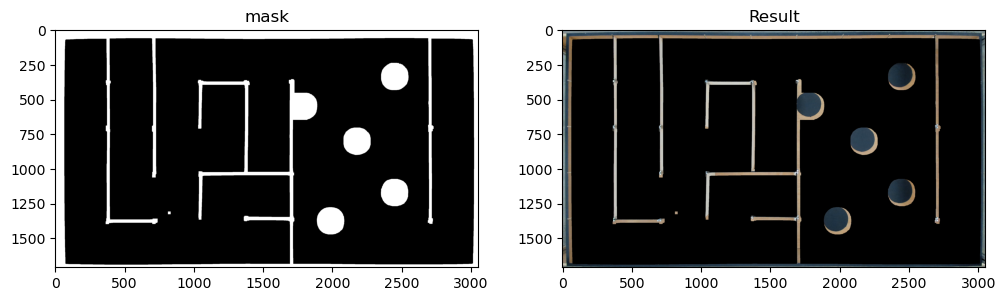

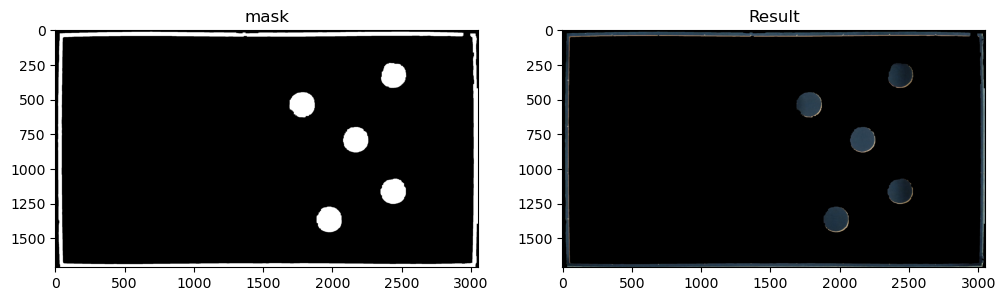

In [1012]:
# Convert the image from BGR to HSV
hsv_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)

HMin = 90
HMax = 120
SMin = 0
SMax = 140
VMin = 0
VMax = 110

lower_bound = np.array([HMin, SMin, VMin])
upper_bound = np.array([HMax, SMax, VMax])
wall_mask = cv2.inRange(hsv_image, lower_bound, upper_bound)

HMin = 93
HMax = 116
SMin = 91
SMax = 171
VMin = 30
VMax = 112
lower_bound = np.array([HMin, SMin, VMin])
upper_bound = np.array([HMax, SMax, VMax])
obstacle_mask = cv2.inRange(hsv_image, lower_bound, upper_bound)


kernel_small = np.ones((1, 1), np.uint8)
kernel_med = np.ones((8, 8), np.uint8)
kernel_large = np.ones((10, 10), np.uint8)

# Morphological opening to remove small objects (debris)
opened_wall_mask = cv2.morphologyEx(wall_mask, cv2.MORPH_OPEN, kernel_small, iterations=1)
opened_obst_mask = cv2.morphologyEx(obstacle_mask, cv2.MORPH_OPEN, kernel_med, iterations=1)

kernel = np.ones((10, 10), np.uint8)
dilated_wall_mask = cv2.dilate(opened_wall_mask, kernel_large, iterations=15)
eroded_wall_mask = cv2.erode(dilated_wall_mask, kernel_large, iterations=13)
masked_wall_image = cv2.bitwise_and(cropped_image, cropped_image, mask=eroded_wall_mask)

dilated_obst_mask = cv2.dilate(opened_obst_mask, kernel_large, iterations=3)
eroded_obst_mask = cv2.erode(dilated_obst_mask, kernel_large, iterations=2)
masked_obst_image = cv2.bitwise_and(cropped_image, cropped_image, mask=eroded_obst_mask)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title('mask')
plt.imshow(eroded_wall_mask, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Result')
plt.imshow(cv2.cvtColor(masked_wall_image, cv2.COLOR_BGR2RGB))

plt.show()
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title('mask')
plt.imshow(eroded_obst_mask, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Result')
plt.imshow(cv2.cvtColor(masked_obst_image, cv2.COLOR_BGR2RGB))

plt.show()

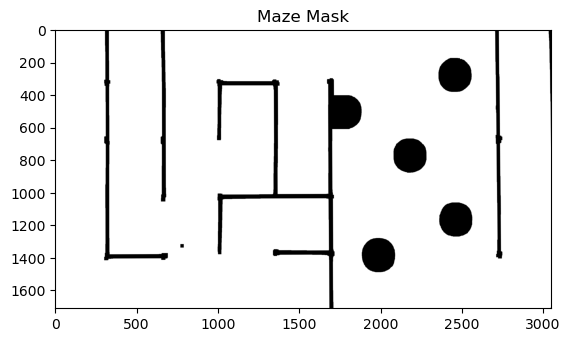

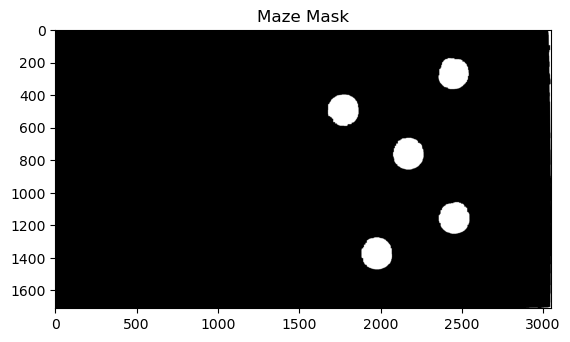

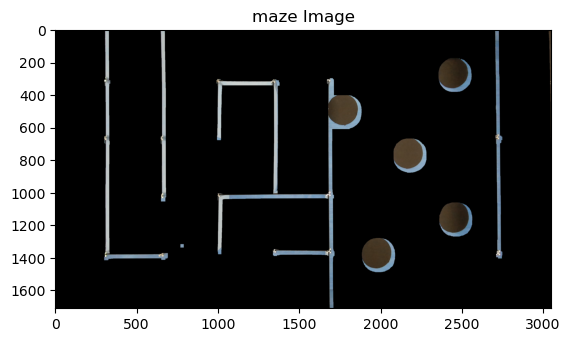

1.3617777777777778 0.7343495350397853


In [1013]:
def get_border_inner_corners(image):
    h, w = image.shape[:2]

    black_pixel_coords = np.column_stack(np.where(image == 0))
    top_left = black_pixel_coords[np.argmin(np.sum(black_pixel_coords, axis=1))]

    rotated_image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    black_pixel_coords = np.column_stack(np.where(rotated_image == 0))
    top_right = black_pixel_coords[np.argmin(np.sum(black_pixel_coords, axis=1))]
    top_right = [w-top_right[1], top_right[0]]

    rotated_image = cv2.rotate(rotated_image, cv2.ROTATE_90_CLOCKWISE)
    black_pixel_coords = np.column_stack(np.where(rotated_image == 0))
    bottom_right = black_pixel_coords[np.argmin(np.sum(black_pixel_coords, axis=1))]
    bottom_right = [w - bottom_right[1], h - bottom_right[0]]

    rotated_image = cv2.rotate(rotated_image, cv2.ROTATE_90_CLOCKWISE)
    black_pixel_coords = np.column_stack(np.where(rotated_image == 0))
    bottom_left = black_pixel_coords[np.argmin(np.sum(black_pixel_coords, axis=1))]
    bottom_left = [bottom_left[1], h - bottom_left[0]]

    return np.array([top_left, top_right, bottom_right, bottom_left])

def corners_transform(image, corners):
    h, w = image.shape[:2]

    src_pts = np.float32(corners)
    dst_pts = np.float32([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]])

    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    warped_image = cv2.warpPerspective(image, M, (image.shape[1], image.shape[0]))

    return warped_image

corners = get_border_inner_corners(eroded_wall_mask)
image_with_corners = cv2.cvtColor(eroded_wall_mask, cv2.COLOR_GRAY2BGR)

maze_image = corners_transform(masked_wall_image, corners)
maze_mask = corners_transform(eroded_wall_mask, corners)
obst_mask = corners_transform(eroded_obst_mask, corners)

maze_mask = cv2.bitwise_not(maze_mask)

# Display the result
plt.imshow(maze_mask, cmap='gray')
plt.title('Maze Mask')
plt.show()
plt.imshow(obst_mask, cmap='gray')
plt.title('Maze Mask')
plt.show()
plt.imshow(maze_image, cmap='gray')
plt.title('maze Image')
plt.show()

pixel2mm = np.mean([maze_mask.shape[1]/(9*250), maze_mask.shape[0]/(5*250)])
mm2pixel = np.mean([(9*250)/maze_mask.shape[1], (5*250)/maze_mask.shape[0]])
print(pixel2mm,mm2pixel)

In [1014]:
class Node:
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y

    def get_point(self):
        return (self.x,self.y)

    def get_ID(self):
        return self.id

class Graph:
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id, x, y)
            self.edges[node_id] = {}

    def add_edge(self, node_id1, node_id2, weight):
        if node_id1 in self.nodes and node_id2 in self.nodes and node_id1 != node_id2:
            self.edges[node_id1][node_id2] = weight
            self.edges[node_id2][node_id1] = weight

    def remove_edge(self, node_id1, node_id2):
        if node_id1 in self.nodes and node_id2 in self.nodes:
            if node_id2 in self.edges[node_id1]:
                del self.edges[node_id1][node_id2]
            if node_id1 in self.edges[node_id2]:
                del self.edges[node_id2][node_id1]

    def get_nodes(self):
        return self.nodes.values()

    def get_node(self, node_id):
        return self.nodes[node_id]

    def get_edge_weight(self, node_id1, node_id2):
        if node_id2 in self.edges[node_id1]:
            return self.edges[node_id1][node_id2]
        return None

    def get_edges(self):
        return self.edges.items()

    def get_node_neighbour_IDs(self, node_id):
        l = list(self.edges[node_id].keys())
        return l

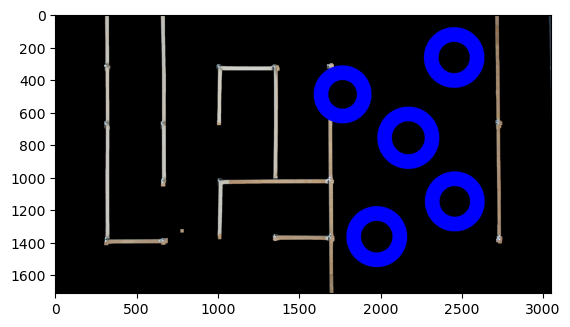

In [1015]:
circle_display_image = maze_image.copy()

def detect_circle_obstacles(gray_image):
    blurred_image = cv2.blur(gray_image, (30, 30))
    detected_circles = cv2.HoughCircles(blurred_image,
                   cv2.HOUGH_GRADIENT, 1, 50, param1 = 50,
                   param2 = 30, minRadius = 80, maxRadius = 200)
    return detected_circles

def draw_circle_obstacles(image, circles):
    for a,b,r in circles[0, :]:
        cv2.circle(image, (a, b), r, (0, 0, 0), -1)

def draw_unsafe_obstacles(image, circles):
    for a,b,r in circles[0, :]:
        cv2.circle(image, (a, b), r+90, (255, 0, 0), -1)

detected_circles = detect_circle_obstacles(obst_mask)
sorted_circles = []
if detected_circles is not None:
    detected_circles = np.uint16(np.around(detected_circles))

    sorted_circles = detected_circles[0, detected_circles[0, :, 0].argsort()]

    draw_unsafe_obstacles(circle_display_image, detected_circles)
    draw_circle_obstacles(circle_display_image, detected_circles)

plt.imshow(cv2.cvtColor(circle_display_image, cv2.COLOR_BGR2RGB))
plt.show()

In [1016]:
# Bresenham's line algorithm to get the pixels along a line
def bresenham(x1, y1, x2, y2):
    pixels = []
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    err = dx - dy

    while True:
        pixels.append((x1, y1))
        if x1 == x2 and y1 == y2:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x1 += sx
        if e2 < dx:
            err += dx
            y1 += sy

    return pixels

def is_free_space(map_image, x, y):
    return np.all(map_image[x, y] == [255, 255, 255])

def path_clear(map_image, node1_coord, node2_coord):

     # Get the pixels along the line
    pixels = bresenham(node1_coord[0], node1_coord[1], node2_coord[0], node2_coord[1])

    # Check for black pixels
    for pixel in pixels:
        if not is_free_space(map_image, pixel[1], pixel[0]):  # Check if the pixel is black
            return False

    return True

def calc_distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def find_closest_node(graph, x, y):
    closest_node_id = None
    min_dist = float('inf')

    for node in graph.get_nodes():
        dist = calc_distance(x, y, node.x, node.y)
        if dist < min_dist:
            closest_node_id = node.get_ID()
            min_dist = dist
    return closest_node_id

def is_grid_system(graph, node, width, n):
    if node.id % n < n - width:
        for i in range(width):
            if (i != width - 1 and node.id + i + 1 not in graph.edges[node.id + i])\
               or node.id + n + i not in graph.edges[node.id + i]:
                return False
        return True
    return False

def is_row_system(graph, node, width, n):
    if node.id % n < n - width:
        for i in range(width):
            if i != width - 1 and node.id + i + 1 not in graph.edges[node.id + i]:
                return False
        return True
    return False

def detect_grid(graph, width, height, n):
    nodes = graph.get_nodes()

    for node in nodes:
        row_count = 0
        # Check for valid width
        curr_node = node
        while is_grid_system(graph, curr_node, width, n):
            row_count += 1
            curr_node = graph.get_node(curr_node.id+n)
            if row_count == height - 1 and is_row_system(graph, curr_node, width, n):
                return (node.id, curr_node.id + width - 1)

    return (None, None)

# remove all circle obstacles from image
def remove_circle_obstacles(image, graph, n, circles):
    # Get the dimensions of the image
    h, w, _ = image.shape

    # Calculate the step size for the grid cells
    step_x = w // (2 * n)

    # define obstacle zone
    left_most_obst_node = graph.get_node(find_closest_node(graph, circles[0,0], circles[0,1]))
    right_most_obst_node = graph.get_node(find_closest_node(graph, circles[len(circles)-1,0], circles[len(circles)-1,1]))
    obst_zone_start = (left_most_obst_node.x - int(step_x-20), 0)
    obst_zone_end = (right_most_obst_node.x + int(step_x-20), h)
    cv2.rectangle(image, obst_zone_start, obst_zone_end, (255,255,255), -1)

def map_fill_nodes(image, graph, n, m):
    h, w, _ = image.shape
    step_x = w // (2 * n)
    step_y = h // (2 * m)
    nodes_coord = []

    for y in range(m):
        for x in range(n):
            mid_x = int(x * 2* step_x + step_x)
            mid_y = int(y * 2* step_y + step_y)
            nodes_coord.append((mid_x, mid_y))

    nodes_coord = np.array(nodes_coord)

    # Fill map with nodes
    for id, node_coord in enumerate(nodes_coord):
        graph.add_node(id, node_coord[0], node_coord[1])

def map_fill_nodes_free_space(image, graph, n, m):
    h, w, _ = image.shape
    step_x = w // (2 * n)
    step_y = h // (2 * m)
    nodes_coord = []

    for y in range(m):
        for x in range(n):
            mid_x = int(x * 2* step_x + step_x)
            mid_y = int(y * 2* step_y + step_y)
            if is_free_space(image, mid_y, mid_x):
                nodes_coord.append((mid_x, mid_y))

    nodes_coord = np.array(nodes_coord)

    # Fill map with nodes
    for id, node_coord in enumerate(nodes_coord):
        graph.add_node(id, node_coord[0], node_coord[1])

def map_fill_edges(image, graph, n, m):
    for node in graph.get_nodes():
        if node.id % n < n - 1:
            right_node = graph.get_node(node.id+1)
            if path_clear(image, node.get_point(), right_node.get_point()):
                graph.add_edge(node.id, right_node.id, 1)
        if node.id // n < m - 1:
            bottom_node = graph.get_node(node.id+n)
            if path_clear(image, node.get_point(), bottom_node.get_point()):
                graph.add_edge(node.id, bottom_node.id, 1)

def define_continuous_zone(image, graph, n):
    # Get the dimensions of the image
    h, w, _ = image.shape

    # Calculate the step size for the grid cells
    step_x = w // (2 * n)
    # Define Continuous Zone (CZ)
    left_most_cz_node_id, right_most_cz_node_id = detect_grid(graph, 3, 5, n)
    if (left_most_cz_node_id, right_most_cz_node_id) != (None, None):
        left_most_cz_node = graph.get_node(left_most_cz_node_id)
        right_most_cz_node = graph.get_node(right_most_cz_node_id)
        cz_zone_start = (left_most_cz_node.x - int(step_x-20), 0)
        cz_zone_end = (right_most_cz_node.x + int(step_x-20), h)
    return (cz_zone_start[0], cz_zone_end[0])

def draw_CZ(image, cz_x_range):
    # display CZ
    cv2.rectangle(image, (cz_x_range[0], 0), (cz_x_range[1], image.shape[0]), (125,0,0), -1)

def add_CZ_start_and_end_coord(image, graph, cz_x_range):
    cz_start_coord = (None, None)
    cz_end_coord = (None, None)
    cz_start_node_id = None
    cz_end_node_id = None
    min_start_dist = float('inf')
    min_end_dist = float('inf')
    for node in graph.get_nodes():
        start_dist = abs(node.x - cz_x_range[0])
        end_dist = abs(node.x - cz_x_range[1])
        if start_dist < min_start_dist and path_clear(image, node.get_point(), (cz_x_range[0],node.y)):
            cz_start_node_id = node.id
            cz_start_coord = (cz_x_range[0], node.y)
            min_start_dist = start_dist
        if end_dist < min_end_dist and path_clear(image, node.get_point(), (cz_x_range[1],node.y)):
            cz_end_node_id = node.id
            cz_end_coord = (cz_x_range[1], node.y)
            min_end_dist = end_dist
    if cz_start_node_id != None and cz_end_node_id != None:
        graph.add_node(-1, cz_start_coord[0], cz_start_coord[1])
        graph.add_edge(-1, cz_start_node_id, 1)
        graph.add_node(-2, cz_end_coord[0], cz_end_coord[1])
        graph.add_edge(-2, cz_end_node_id, 1)

def display_all_nodes(image, graph):
    for node in graph.get_nodes():
        cv2.putText(image, str(node.id), node.get_point(), cv2.FONT_HERSHEY_SIMPLEX, 3, (0, 255, 0), 5)
        cv2.circle(image, (node.x, node.y), 20, (0, 255, 0), -1)

def display_all_edges(image, graph):
    for node_id1, neighbours in graph.edges.items():
        for node_id2, _ in neighbours.items():
            node1 = graph.nodes[node_id1]
            node2 = graph.nodes[node_id2]
            cv2.line(image, (node1.x, node1.y), (node2.x, node2.y), (0, 125, 0), 10)

def display_grid_map(image, graph):
    # Display nodes
    display_all_nodes(image, graph)

    # Display edges
    display_all_edges(image, graph)

    return image

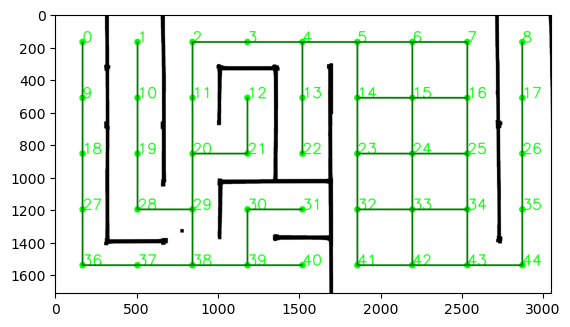

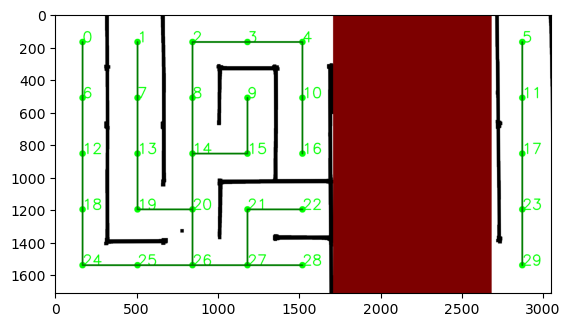

In [1017]:
maze_map = cv2.cvtColor(maze_mask, cv2.COLOR_GRAY2BGR)
cz_map = cv2.cvtColor(maze_mask, cv2.COLOR_GRAY2BGR)
maze_graph = Graph()
map_fill_nodes(maze_map, maze_graph, 9, 5)
remove_circle_obstacles(maze_map, maze_graph, 9, sorted_circles)
map_fill_edges(maze_map, maze_graph, 9, 5)
# Display Resulting Image
plt.imshow(display_grid_map(maze_map.copy(), maze_graph))
plt.show()

cz_range = define_continuous_zone(cz_map, maze_graph, 9)
draw_CZ(cz_map, cz_range)
maze_graph = Graph()
map_fill_nodes_free_space(cz_map, maze_graph, 9, 5)
map_fill_edges(cz_map, maze_graph, 6, 5)
# Display Resulting Image
plt.imshow(display_grid_map(cz_map, maze_graph))
plt.show()

add_CZ_start_and_end_coord(maze_map, maze_graph, cz_range)

# Continuous Planning Zone Path Planning - RRT*
## Setup Configuration Space

In [1018]:
def draw_divets(image, n, m):
    h, w, _ = image.shape
    step_x = w // (2 * n) * 2
    step_y = h // (2 * m) * 2
    nodes_coord = []

    for y in range(m - 1):
        for x in range(n - 1):
            mid_x = int(x * step_x + step_x)
            mid_y = int(y * step_y + step_y)
            cv2.circle(image, (mid_x, mid_y), 80, (255, 0, 0), -1)

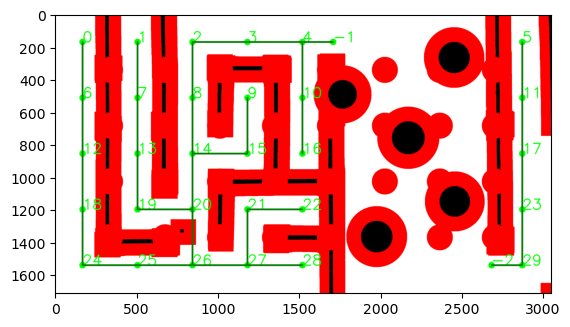

In [1019]:
maze_and_obst_map = maze_map.copy()

kernel = np.ones((10, 10), np.uint8)
erosion = cv2.erode(maze_and_obst_map, kernel, iterations = 15)

gray_image = cv2.cvtColor(maze_and_obst_map, cv2.COLOR_BGR2GRAY)
gray_erosion = cv2.cvtColor(erosion, cv2.COLOR_BGR2GRAY)
_, image_mask = cv2.threshold(gray_image, 127, 255, cv2.THRESH_BINARY)
_, erosion_mask = cv2.threshold(gray_erosion, 127, 255, cv2.THRESH_BINARY)

unsafe_mask = ~image_mask | erosion_mask

config_space = maze_and_obst_map.copy()

indices = np.where(unsafe_mask == 0)

config_space[indices[0], indices[1]] = [255,0,0]

draw_divets(config_space, 9, 5)
draw_unsafe_obstacles(config_space, detected_circles)
draw_circle_obstacles(config_space, detected_circles)

plt.imshow(display_grid_map(config_space.copy(), maze_graph))
plt.show()

## Implement RRT*

In [1020]:
# Given a random point it extends the tree by either the step distance or the cartesian distance
def calculate_new_tree_point(map_image, target_x, target_y, nearest_x, nearest_y, step):
    # Calculate the distance between the nearest node and the target point
    distance = calc_distance(target_x, target_y, nearest_x, nearest_y)

    if distance <= step:
        return (target_x, target_y), distance

    angle = math.atan2(target_y - nearest_y, target_x - nearest_x)
    new_x = nearest_x + step * math.cos(angle)
    new_y = nearest_y + step * math.sin(angle)

    if path_clear(map_image, (int(new_x), int(new_y)), (nearest_x, nearest_y)):
        return (int(new_x), int(new_y)), step
    return (0,0), 0

# Finds and returns the closest node to a point on the image
def find_closest_node_rrt(map_image, graph, x, y):
    closest_node_id = None
    min_dist = float('inf')

    for node in graph.get_nodes():
        dist = calc_distance(x, y, node.x, node.y)
        if dist < min_dist and path_clear(map_image, (node.x, node.y), (x, y)):
            closest_node_id = node.get_ID()
            min_dist = dist
    return closest_node_id

def select_target_coord(boundry, end_coord, beta):
    if random.random() < beta:
        target_coord = end_coord
    else:
        x = random.randint(boundry[0][1], boundry[1][1]-1)
        y = random.randint(boundry[0][0], boundry[1][0]-1)
        target_coord = (y, x)
    return target_coord

def within_goal_radius(coord, goal_coord, radius):
    return calc_distance(coord[0], coord[1], goal_coord[0], goal_coord[1]) <= radius

# Finds the best (lowest cost) node within a search radius
def find_node_best(map_image, graph, node_new, cost, range):
    node_best_id = None
    min_cost = float('inf')
    dist = 0

    for node in graph.get_nodes():
        if node.id == node_new.id:
            continue
        # Calculate the distance between the current node and the new node
        distance = calc_distance(node.x, node.y, node_new.x, node_new.y)

        if path_clear(map_image, (node.x, node.y), (node_new.x, node_new.y)) and distance <= range:
            # Calculate the new cost if this node is selected as the best node
            new_cost = cost[node.id] + distance

            # Check if this new cost is lower than the current minimum cost
            if new_cost < min_cost:
                min_cost = new_cost
                node_best_id = node.id
                dist = distance

    return node_best_id, dist

def rewire_rrt(map_image, graph, cost, node_new_id, range):
    node_new = graph.get_node(node_new_id)
    near_nodes = get_near_nodes(graph, node_new, range)

    for node in near_nodes:
        edge_node = (node.x, node.y)
        if path_clear(map_image, (node_new.x, node_new.y), edge_node):
            potential_new_cost = cost[node_new_id] + calc_distance(node_new.x, node_new.y, node.x, node.y)
            if potential_new_cost < cost[node.id] and not creates_cycle(graph, node_new_id, node.id):
                update_graph(graph, cost, node_new_id, node, potential_new_cost)

def get_near_nodes(graph, node_new, range):
    near_nodes = []
    for node in graph.get_nodes():
        if node.id == node_new.id:
            continue
        if calc_distance(node_new.x, node_new.y, node.x, node.y) <= range:
            near_nodes.append(node)
    return near_nodes

def update_graph(graph, cost, node_new_id, node, new_cost):
    old_parent_id = find_parent_id(graph, node.id)
    if old_parent_id is not None:
        graph.remove_edge(old_parent_id, node.id)
    graph.add_edge(node_new_id, node.id, calc_distance(graph.get_node(node_new_id).x, graph.get_node(node_new_id).y, node.x, node.y))
    cost[node.id] = new_cost
    propagate_cost_to_leaves(graph, cost, node.id)

def find_parent_id(graph, node_id):
    for parent_id, children in graph.get_edges():
        if node_id in children:
            return parent_id
    return None

def creates_cycle(graph, node_new_id, node_id):
    visited = set()
    stack = [node_id]
    while stack:
        current = stack.pop()
        if current in visited:
            continue
        visited.add(current)
        if current == node_new_id:
            return True
        stack.extend(graph.get_node_neighbour_IDs(current))
    return False

def propagate_cost_to_leaves(graph, cost, node_id):
    children = graph.get_node_neighbour_IDs(node_id)
    for child_id in children:
        new_cost = cost[node_id] + calc_distance(graph.get_node(node_id).x, graph.get_node(node_id).y, graph.get_node(child_id).x, graph.get_node(child_id).y)
        if new_cost < cost[child_id]:
            cost[child_id] = new_cost
            propagate_cost_to_leaves(graph, cost, child_id)


def creates_cycle(graph, node_new_id, node_id):
    visited = set()
    stack = [node_id]
    while stack:
        current = stack.pop()
        if current in visited:
            continue
        visited.add(current)
        if current == node_new_id:
            return True
        for neighbor_id in graph.get_node_neighbour_IDs(current):
            stack.append(neighbor_id)
    return False



def rrt_star(map_image, graph, start_id, start_coord, end_id, end_coord, n, alpha, beta, end_radius, range):
    graph.add_node(start_id, start_coord[0], start_coord[1])
    cost = [float('inf')] * (n + 1)  # Initialize cost array with infinity
    cost[start_id] = 0
    i = 0
    boundry = (start_coord, end_coord)

    while i <= n:
        target_coord = select_target_coord(boundry, end_coord, beta)
        node_near_id = find_closest_node_rrt(map_image, graph, target_coord[0], target_coord[1])
        if node_near_id is None:
            continue
        node_near = graph.get_node(node_near_id)
        node_new_coord, node_new_dist = calculate_new_tree_point(map_image, target_coord[0], target_coord[1], node_near.x, node_near.y, alpha)

        if node_new_dist == 0:
            continue

        if within_goal_radius(node_new_coord, end_coord, end_radius):  # Reaches goal within radius
            node_new_coord = end_coord
            node_new_id = end_id
        else:
            node_new_id = i
            i += 1

        graph.add_node(node_new_id, node_new_coord[0], node_new_coord[1])
        node_new = graph.get_node(node_new_id)
        node_best_id, node_best_dist = find_node_best(map_image, graph, node_new, cost, range)
        graph.add_edge(node_new_id, node_best_id, node_best_dist)
        cost[node_new_id] = cost[node_best_id] + node_best_dist
        rewire_rrt(map_image, graph, cost, node_new_id, range)

        if node_new_id == end_id:
            break

class PriorityQueue:
    def __init__(self) -> None:
        self.__queue = []
    def __str__(self) -> str:
        return ' '.join([str(i) for i in self.__queue])
    def isEmpty(self):
        return len(self.__queue) == 0
    def push(self, data):
        self.__queue.append(data)
        self.__queue.sort(key=lambda x: x[1])
    def pop(self):
        return self.__queue.pop(0)

def dijkstra(graph, start_id, end_id):
    pq = PriorityQueue()
    pq.push((end_id, 0))

    visited = [False] * (len(graph.nodes) + 2)
    visited[end_id] = True

    prev = [None] * (len(graph.nodes) + 2)
    cost = [float('inf')] * (len(graph.nodes) + 2)
    cost[end_id] = 0
    while not pq.isEmpty():
        node_id,curr_cost = pq.pop()
        visited[node_id] = True
        for neighbour_id in graph.get_node_neighbour_IDs(node_id):
            if not visited[neighbour_id]:
                new_cost = curr_cost + graph.get_edge_weight(node_id, neighbour_id)
                if new_cost < cost[neighbour_id]:
                    prev[neighbour_id] = node_id
                    cost[neighbour_id] = new_cost
                    pq.push((neighbour_id, cost[neighbour_id]))
    path = []
    curr_node_id = start_id
    while curr_node_id != None:
        path.append(curr_node_id)
        curr_node_id = prev[curr_node_id]
    total_cost = cost[start_id]

    return (path, total_cost)

def draw_path(image, graph, path):
    for i in range(len(path) - 1):
        node1 = graph.get_node(path[i])
        node2 = graph.get_node(path[i+1])
        cv2.line(image, (node1.x, node1.y), (node2.x, node2.y), (0, 0, 125), 5)

def node_exists(graph, node_id):
    return any(node.get_ID() == node_id for node in graph.get_nodes())

[-1, 5, 12, 22, 25, 50, 81, 109, 139, -2] 1892.7615120146695


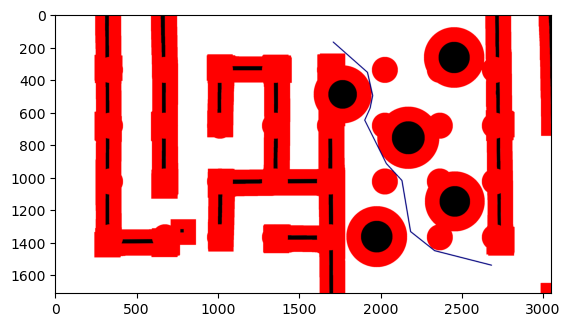

In [1027]:
start_id = -1
end_id = -2

random.seed(42)
rrt_star_image = config_space.copy()
rrt_star_graph = Graph()

rrt_star_beta = 0.4
rrt_star_search_range = 1000
start_node = maze_graph.get_node(start_id)
start_location = start_node.get_point()
end_node = maze_graph.get_node(end_id)
goal_location = end_node.get_point()
iterations = 500
step = 80
goal_radius = 100
rrt_star(config_space, rrt_star_graph, start_id, start_location, end_id, goal_location, iterations, step, rrt_star_beta, goal_radius, rrt_star_search_range)
# display_grid_map(rrt_star_image, rrt_star_graph)
if node_exists(rrt_star_graph, end_id):
    path,cost = dijkstra(rrt_star_graph, start_id, end_id)
    print(path, cost)
    draw_path(rrt_star_image, rrt_star_graph, path)

plt.imshow(rrt_star_image)
plt.show()

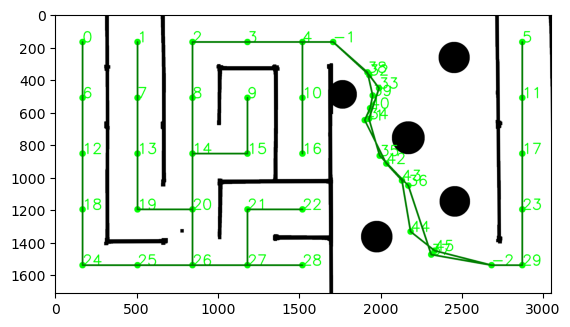

In [1028]:
path_nodes = {id: rrt_star_graph.get_node(id).get_point() for id in path}

prev_id = start_id
i = len(maze_graph.nodes)
for id,coord in path_nodes.items():
    if id == start_id:
        continue
    elif id == end_id:
        maze_graph.add_edge(prev_id, id, 1)
        continue
    maze_graph.add_node(i, coord[0], coord[1])
    maze_graph.add_edge(prev_id, i, 1)
    prev_id = i
    i += 1

maze_and_obst_map = maze_map.copy()
draw_circle_obstacles(maze_and_obst_map, detected_circles)
plt.imshow(display_grid_map(maze_and_obst_map.copy(),maze_graph))
plt.show()

# Implement BFS to all path

In [1023]:
def bfs(graph, start_node_id, end_node_id):
    queue = []
    queue.append(start_node_id)

    visited = [False] *(len(graph.nodes)+2)
    visited[start_node_id] = True

    prev = [None] * (len(graph.nodes)+2)
    while len(queue):  # while queue is not empty
        curr_node_id = queue.pop(0)
        neighbour_ids = graph.get_node_neighbour_IDs(curr_node_id)
        for neighbour_id in neighbour_ids:
            if not visited[neighbour_id]:
                queue.append(neighbour_id)
                visited[neighbour_id] = True
                prev[neighbour_id] = curr_node_id

    path = []
    curr_node_id = end_node_id
    while curr_node_id != None:
        path.append(curr_node_id)
        curr_node_id = prev[curr_node_id]
    path.reverse()

    # Check if the path is valid
    if path[0] == start_node_id:
        return path
    return []  # return an empty list if no valid path is found

In [1024]:
path = bfs(maze_graph, 0, 5)
print(path)

[0, 6, 12, 18, 24, 25, 26, 20, 14, 8, 2, 3, 4, -1, 32, 33, 34, 35, 36, 37, -2, 29, 23, 17, 11, 5]
38


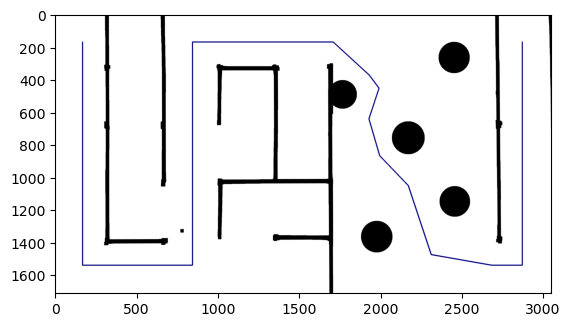

In [1025]:
path_map = maze_and_obst_map.copy()
draw_path(path_map, maze_graph, path)
plt.imshow(path_map)
plt.show()